## Pseudo-random number generators

## Properties of PRNGs

+ dimension of output
    - commonly 32 bits, but some have more
    
+ number of states
    - dimension of state space in bits
    - sometimes state = output, but better generators generally have output = f(state)

+ period
    - maximum over initial states of the number of states visited before repeating
    - period &le; number of states
    - if state has $s$ bits, period $\le 2^s$
    - for some PRNGs, period is much less than number of states
    - for some seeds for some PRNGs, number of states visited is much less than period
    
+ $k$-distribution
    - suppose $\{X_i\}$ is sequence of $P$ $w$-bit integers
    - define $t_v(X_i)$ to be the first $v$ bits of $X_i$
    - $\{X_i\}$ is $k$-distributed to $v$-bit accuracy if each of the $2^{kv}-1$ possible nonzero $kv$-bit vectors occurs equally often among the $P$ $kv$-bit vectors
$$ (t_v(X_i),\,t_v(X_{i+1}), \ldots ,t_v(X_{i+k-1}))\quad (0\le i<P),$$
and the zero vector occurs once less often.
    - amounts to a form of uniformity in $k$-dimensional space, over an entire cycle
    - does not measure dependence or other "serial" properties

+ sensitivity to initial state; burn-in
    - many PRNGs don't do well if the seed has too many zeros
    - some require many iterations before output behaves well
    - for some seeds, some PRNGs repeat very quickly

## Some PRNGs

### Middle Square

Dates to Franciscan friar ca. 1240 (per [Wikipedia](https://en.wikipedia.org/wiki/Middle-square_method)); reinvented by von Neumann ca. 1949.

Take $n$-digit number, square it, use middle $n$ digits as the "random" and the new seed.

E.g., for $n=4$, take $X_0 = 1234$.

$1234^2 = 1522756$, so $X_1 = 2275$.

$2275^2 = 5175625$, so $X_2 = 7562$.

+ $10^n$ possible states, but not all attainable from a given seed
+ period at most $8^n$, but can be very short. E.g., for $n=4$,
    - 0000, 0100, 2500, 3792, & 7600 repeat forever
    - 0540 &rightarrow; 2916 &rightarrow; 5030 &rightarrow; 3009 &rightarrow; 0540

### Linear Congruential Generators (LCGs) 

$$ X_{n+1} = (aX_n +c)\mod m.$$

LCG period is at most $m$.

#### Hull-Dobell Theorem: the period of an LCG is $m$ for all seeds $X_0$ iff

+ $m$ and $c$ are relatively prime
+ $a-1$  is divisible by all prime factors of $m$
+ $a-1$  is divisible by 4 if $m$ is divisible by 4

#### Marsaglia (PNAS, 1968): Random Numbers Fall Mainly in the Planes
Multiplicative congruential generators ($c=0$), Lehmer (1949).

![Marsaglia68](./RandPics/marsaglia68.png)

### RANDU

RANDU is a particularly bad [linear congruential generator](https://en.wikipedia.org/wiki/Linear_congruential_generator) promulgated in the 1960s and widely copied.

RANDU is given by the recursion

$$ X_{j+1} = 65539 X_j\mod 2^{31}.$$

Period is ($2^{29}$); all outputs are odd integers. 

Triples of values from RANDU fall on 15 planes in 3-dimensional space, as shown below.

In [1]:
%matplotlib inline
from __future__ import division
import math
import numpy as np
import scipy as sp
from scipy.misc import comb, factorial
from scipy.optimize import brentq
from scipy.stats import chisquare, norm
import scipy.integrate
from random import Random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# LCG; defaults to RANDU, a particularly bad choice
class lcgRandom: # defaults to RANDU: BEWARE!
    def __init__(self, seed=1234567890, A=0, B=65539, M = 2**31): 
        self.state = seed
        self.A = A
        self.B = B
        self.M = M
        
    def getState(self):
        return self.state, self.A, self.B, self.M
    
    def setState(self,seed=1234567890, A=0, B=65539, M = 2**31):
        self.state = seed
        self.A = A
        self.B = B
        self.M = M

    def nextRandom(self):
        self.state = (self.A + self.B * self.state) % self.M
        return self.state/self.M

    def random(self, size=None):  # vector of rands
        if size==None:
            return self.nextRandom()
        else: 
            return np.reshape(np.array([self.nextRandom() for i in np.arange(np.prod(size))]), size)
    
    def randint(self, low=0, high=None, size=None):  # integer between low (inclusive) and high (exclusive)
        if high==None:  # numpy.random.randint()-like behavior
            high, low = low, 0
        if size==None:
            return low + np.floor(self.nextRandom()*(high-low)) # NOT AN ACCURATE ALGORITHM! See below.
        else:
            return low + np.floor(self.random(size=size)*(high-low))
        

In [3]:
# generate triples using RANDU
reps = int(10**5)
randu = lcgRandom(12345)
xs = np.transpose(randu.random(size=(reps,3)))

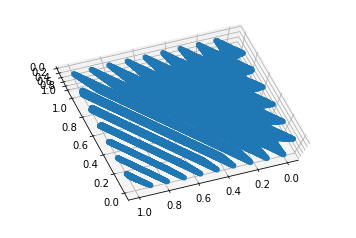

In [4]:
# plot the triples as points in R^3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs[0],xs[1], xs[2])

plt.rcParams['figure.figsize'] = (18.0, 18.0) 

ax.view_init(-100,110)

plt.show()

### Wichmann-Hill (1982)

Sum of 3 LCGs. Period is 6,953,607,871,644. 

    def WH(s1, s2, s3):
        s1 = (171 * s1) % 30269
        s2 = (172 * s2) % 30307
        s3 = (170 * s3) % 30323
        r = (s1/30269 + s2/30307 + s3/30323) %  1
        return [r, s1, s2, s3]

#### The right way, the wrong way, and the Microsoft way.
WH generally not considered adequate for statistics, but was (nominally) the PRNG in Excel for several
generations. Excel did not allow the seed to be set, so analyses were not reproducible. 

![mcCullough](./RandPics/notWichmannHill08.png)
McCullough, B.D., 2008. Microsoft Excel's 'Not The Wichmann–Hill' random number generators
_Computational Statistics & Data Analysis_, _52_, 4587&ndash;4593
doi:10.1016/j.csda.2008.03.006

### Mersenne Twister (MT)  Matsumoto & Nishimura (1997)

+ example of "twisted generalized feedback shift register"
+ period $2^{19937}-1$, a Mersenne Prime
+ $k$-distributed to 32-bit accuracy for all $k \in \{1, \ldots, 623\}$. 
+ passes DIEHARD and most of TestU01 (see below)
+ standard in many packages:
    - GNU Octave, Maple, MATLAB, Mathematica, Python, R, Stata
    - Apache, CMU Common Lisp, Embeddable Common Lisp, Free Pascal, GLib, PHP, GAUSS, IDL, Julia, Ruby, SageMath, Steel Bank Common Lisp, Scilab, Stata, GNU Scientific Library, GNU Multiple Precision Arithmetic Library, Microsoft Visual C++.
    - SPSS and SAS offer MT, as does C++ (v11 and up)
+ generally considered adequate for statistics (but not for cryptography); however, will trouble that in this work, esp. for "big data"
+ usual implementation has 624-dimensional state space, but TinyMT uses only 127 bits
+ seeding complicated, since state is an array
+ can take a while to "burn in," especially for seeds with many zeros
+ output for close seed states can be close
+ 2002 update improves seeding
+ completely predictable from 624 successive outputs
+ problems discovered in 2007 (see TestU01, below)

In [6]:
# Python implementation of MT19937 from Wikipedia 
# https://en.wikipedia.org/wiki/Mersenne_Twister#Python_implementation

def _int32(x):
    # Get the 32 least significant bits.
    return int(0xFFFFFFFF & x)

class MT19937:

    def __init__(self, seed):
        # Initialize the index to 0
        self.index = 624
        self.mt = [0] * 624
        self.mt[0] = seed  # Initialize the initial state to the seed
        for i in range(1, 624):
            self.mt[i] = _int32(
                1812433253 * (self.mt[i - 1] ^ self.mt[i - 1] >> 30) + i)

    def extract_number(self):
        if self.index >= 624:
            self.twist()

        y = self.mt[self.index]

        # Right shift by 11 bits
        y = y ^ y >> 11
        # Shift y left by 7 and take the bitwise and of 2636928640
        y = y ^ y << 7 & 2636928640
        # Shift y left by 15 and take the bitwise and of y and 4022730752
        y = y ^ y << 15 & 4022730752
        # Right shift by 18 bits
        y = y ^ y >> 18

        self.index = self.index + 1

        return _int32(y)

    def twist(self):
        for i in range(624):
            # Get the most significant bit and add it to the less significant
            # bits of the next number
            y = _int32((self.mt[i] & 0x80000000) +
                       (self.mt[(i + 1) % 624] & 0x7fffffff))
            self.mt[i] = self.mt[(i + 397) % 624] ^ y >> 1

            if y % 2 != 0:
                self.mt[i] = self.mt[i] ^ 0x9908b0df
        self.index = 0

### xorshift family

Originated by Marsaglia, 2003.

Vigna, S., 2014. Further scramblings of Marsaglia's xorshift generators. https://arxiv.org/abs/1404.0390

128-bit xorshift+  Implemented in Python package randomstate https://pypi.python.org/pypi/randomstate/1.10.1

    uint64_t s[2];

    uint64_t xorshift128plus(void) {
	    uint64_t x = s[0];
	    uint64_t const y = s[1];
	    s[0] = y;
	    x ^= x << 23; // a
	    s[1] = x ^ y ^ (x >> 17) ^ (y >> 26); // b, c
	    return s[1] + y;
    }
    
    
1024-bit xorshift+

    uint64_t s[16];
    int p;
    
    uint64_t next(void) {
        const uint64_t s0 = s[p];
        uint64_t s1 = s[p = (p + 1) & 15];
        const uint64_t result = s0 + s1;
        s1 ^= s1 << 31; // a
        s[p] = s1 ^ s0 ^ (s1 >> 11) ^ (s0 >> 30); // b, c
    return result;
}

xorshift+ passes all the tests in BigCrush, has 128-bit state space and period $2^{128}-1$, but is 
only $(k-1)$-dimensionally equidistributed, where $k$ is the dimension of the distribution of the xorshift
generator from which it's derived. E.g., for the 128-bit version, xorshift+ is only 1-dimensionally equidistributed.

## Other non-cryptographic PRNGs

See http://www.pcg-random.org/ and the talk http://www.pcg-random.org/posts/stanford-colloquium-talk.html

PCG family permutes the output of a LCG; good statistical properties and very fast and compact. Related to Rivest's RC5 cipher.

Seems better than MT, xorshift+, et al. 

    // *Really* minimal PCG32 code / (c) 2014 M.E. O'Neill / pcg-random.org
    // Licensed under Apache License 2.0 (NO WARRANTY, etc. see website)

    typedef struct { uint64_t state;  uint64_t inc; } pcg32_random_t;

    uint32_t pcg32_random_r(pcg32_random_t* rng)
    {
        uint64_t oldstate = rng->state;
        // Advance internal state
        rng->state = oldstate * 6364136223846793005ULL + (rng->inc|1);
        // Calculate output function (XSH RR), uses old state for max ILP
        uint32_t xorshifted = ((oldstate >> 18u) ^ oldstate) >> 27u;
        uint32_t rot = oldstate >> 59u;
        return (xorshifted >> rot) | (xorshifted << ((-rot) & 31));
    }

## PRNGs based on cryptographic hash functions

Cryptographic hash functions have several basic properties:

1. produce fixed-length "digest" of an arbitrarily long "message": $H:\{0, 1\}^* \rightarrow \{0, 1\}^L$.
1. inexpensive to compute
1. non-invertible ("one-way," hard to find pre-image of any hash except by exhaustive enumeration)
1. collision-resistant (hard to find $M_1 \ne M_2$ such that $H(M_1) = H(M_2)$)
1. small change to input produces big change to output ("unpredictable," input and output effectively independent)
1. equidistributed: bits of the hash are essentially random 

Summary: _as if_ $H(M)$ is random $L$-bit string is assigned to $M$ in a way that's essentially unique.

## 1 step of SHA-256
By User:kockmeyer - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=1823488

![SHA-2](./RandPics/SHA-2.svg)

$$ \mbox{Ch} (E,F,G) \equiv (E\land F)\oplus (\neg E\land G) $$
$$ \mbox{Ma} (A,B,C) \equiv (A\land B)\oplus (A\land C)\oplus (B\land C) $$
$$ \Sigma _0 (A) \equiv (A\!\ggg \!2)\oplus (A\!\ggg \!13)\oplus (A\!\ggg \!22) $$
$$ \Sigma _1 (E) \equiv (E\!\ggg \!6)\oplus (E\!\ggg \!11)\oplus (E\!\ggg \!25) $$
$$\boxplus  \mbox{ is addition mod } 2^{32}$$

#### Simple, hash-based PRNG

Generate a random string $S$ of reasonable length, e.g., 20 digits.

$$ X_i = {\mbox{Hash}}(S+i),$$

where $+$ denotes string concatenation, and the resulting string is interpreted as a (long) hexadecimal number.

**"Counter mode."  Hash-based generators of this type have unbounded state spaces.**

Implementation in Python by Ron Rivest: http://people.csail.mit.edu/rivest/sampler.py

Implementation in angular-js by Chris Jerdonek: https://github.com/cjerdonek/quick-sampler

Implementation in JavaScript by Philip Stark: https://www.stat.berkeley.edu/~stark/Java/Html/sha256Rand.htm



# Some trainwrecks

## Microsoft Visual Studio system.random, 2011

![Microsoft](./RandPics/visualStudiosysRand.png)

https://connect.microsoft.com/VisualStudio/feedback/details/634761/system-random-serious-bug

![XP2](./RandPics/xp2k.png)

## Aristocrat Leisure of Australia Slot Machines

<img src="./RandPics/wiredRussianSlot.png" alt="Wired Slots" height="600px" />

<img src="./RandPics/russiaLeisure.png" alt="Russian hack" height="600px" />

## Dual Elliptic Curve

![dual EC](./RandPics/dualEC-1.png)

---
![dual EC](./RandPics/dualEC-2.png)
Bernstein, D.J., T. Lange, and R. Niederhagen, 2016. Dual EC: A Standardized Backdoor, in _The New Codebreakers, Essays Dedicated to David Kahn on the Occasion of his 85th Birthday_, Ryan, P.Y.A., D. Naccache, and J-J Quisquater, eds., Springer, Berlin.

----
## GnuPG RNG bug (18 years, 1998--2016) 

"An attacker who obtains 4640 bits from the RNG can trivially predict the next 160 bits of output" 

https://threatpost.com/gpg-patches-18-year-old-libgcrypt-rng-bug/119984/

---
## RSA

https://www.schneier.com/blog/archives/2012/02/lousy_random_nu.html

![Lenstra](./RandPics/lenstraEtal.png)

"An analysis comparing millions of RSA public keys gathered from the Internet was announced in 2012 by Lenstra, Hughes, Augier, Bos, Kleinjung, and Wachter. They were able to factor 0.2% of the keys using only Euclid's algorithm. They exploited a weakness unique to cryptosystems based on integer factorization. If n = pq is one public key and n′ = p′q′ is another, then if by chance p = p′, then a simple computation of gcd(n,n′) = p factors both n and n′, totally compromising both keys. Nadia Heninger, part of a group that did a similar experiment, said that the bad keys occurred almost entirely in embedded applications, and explains that the one-shared-prime problem uncovered by the two groups results from situations where the pseudorandom number generator is poorly seeded initially and then reseeded between the generation of the first and second primes."

---
## PHP

![php](./RandPics/argyrosKiayias.png)

---
## Bitcoin on Android: Java nonce collision 

"In August 2013, it was revealed that bugs in the Java class SecureRandom could generate collisions in the k nonce values used for ECDSA in implementations of Bitcoin on Android. When this occurred the private key could be recovered, in turn allowing stealing Bitcoins from the containing wallet."

https://en.wikipedia.org/wiki/Random_number_generator_attack#Java_nonce_collision

## Debian OpenSSL

![openSSL](./RandPics/openSSL.png)

Valgrind and Purify warned about uninitialized data. 
Only remaining entropy in seed was the process ID. 

Default maximum process ID is 32,768 in Linux.

Took 2 years (2006--2008) to notice the bug.

XKCD 
![xkcd](https://imgs.xkcd.com/comics/security_holes.png)

---
### Generating a random integer uniformly distributed on $\{1, \ldots, m\}$


#### Naive method
A standard way to generate a random integer is to start with $X \sim U[0,1)$ and define $Y \equiv 1 + \lfloor mX \rfloor$. 

In theory, that's fine. But in practice, $X$ is not really $U[0,1)$ but instead is derived by normalizing a PRN
that's uniform on $w$-bit integers. Then, unless $m$ is a power of 2, the distribution of $Y$ isn't uniform on $\{1, \ldots, m\}$. For $m < 2^w$, the ratio of the largest to smallest selection probability 
is, to first order,  $1+ m 2^{-w}$. (See, e.g., Knuth v2 3.4.1.A.)

For $m = 10^9$ and $w=32$, $1 + m 2^{-w} \approx 1.233$. That could easily matter.

For $m > 2^{w}$, at least $m-2^w$ values will have probability 0 instead of probability $1/m$. 

If $w=32$, then for $m>2^{32}=4.24e9$, some values will have probability 0. Until relatively recently, R did not support 64-bit integers.

#### More accurate method
A better way to generate a (pseudo-)random integer on $\{1, \ldots m\}$ from a (pseudo-random) $w$-bit integer in practice is as follows:

1. Set $\mu = \log_2(m-1)$.
1. Define a $w$-bit _mask_ consisting of $\mu$ bits set to 1 and $(w-\mu)$ bits set to zero.
1. Generate a random $w$-bit integer $Y$. 
1. Define $y$ to be the bitwise `and` of $Y$ and the mask.
1. If $y \le m-1$, output $x = y+1$; otherwise, return to step 3.

This is how random integers are generated in numpy by `numpy.random.randint()`.
However, `numpy.random.choice()` does something else that's biased: it finds the closest integer to $mX$.

In `R`, one would generally use the function `sample(1:m, k, replace=FALSE)` to draw pseudo-random
integers. 
It seems that `sample()` uses the faulty `1 + floor(m*X)` approach. 

---
## R random integer generator / sample()

```
if (dn > INT_MAX || k > INT_MAX) {
	    PROTECT(y = allocVector(REALSXP, k));
	    if (replace) {
		double *ry = REAL(y);
		for (R_xlen_t i = 0; i < k; i++) ry[i] = floor(dn * ru() + 1);
 	    } else {
#ifdef LONG_VECTOR_SUPPORT
		R_xlen_t n = (R_xlen_t) dn;
		double *x = (double *)R_alloc(n, sizeof(double));
		double *ry = REAL(y);
		for (R_xlen_t i = 0; i < n; i++) x[i] = (double) i;
		for (R_xlen_t i = 0; i < k; i++) {
		    R_xlen_t j = (R_xlen_t)floor(n * ru());
		    ry[i] = x[j] + 1;
		    x[j] = x[--n];
		}
#else
		error(_("n >= 2^31, replace = FALSE is only supported on 64-bit platforms"));
#endif
	    }
	} else {
	    int n = (int) dn;
	    PROTECT(y = allocVector(INTSXP, k));
	    int *iy = INTEGER(y);
	    /* avoid allocation for a single sample */
	    if (replace || k < 2) {
		for (int i = 0; i < k; i++) iy[i] = (int)(dn * unif_rand() + 1);
	    } else {
		int *x = (int *)R_alloc(n, sizeof(int));
		for (int i = 0; i < n; i++) x[i] = i;
		for (int i = 0; i < k; i++) {
 		    int j = (int)(n * unif_rand());
 		    iy[i] = x[j] + 1;
 		    x[j] = x[--n];
 		}
 	}
```
```
/* Our PRNGs have at most 32 bit of precision, and all have at least 25 */

static R_INLINE double ru()
{
    double U = 33554432.0;
    return (floor(U*unif_rand()) + unif_rand())/U;
}
```

----
## How can you tell whether a sequence is random?

http://dilbert.com/strip/2001-10-25

## Tests of PRNGS

+ Theoretical analyses, e.g., Knuth (1969), Marsaglia (1968)

+ Statistical tests

#### Knuth (1969) _The Art of Computer Programming_, v.2 

+ 11 types of behavior: equidistribution, series, gaps, poker, coupon collector, permutation frequency, runs, max of $t$, collisions, birthday spacings, serial correlation
+ tests on subsequences, spectral test
+ Many $\chi^2$-based tests
+ Kolmogorov-Smirnov test for uniformity
+ Sphere-packing
+ **MORE**

#### Marsaglia (1996) DIEHARD tests

+ Birthday spacings
+ Overlapping permutations of 5 random numbers
+ Ranks of binary matrices of various dimensions
+ Monkeys at typewriters: count overlapping "words" in strings of bits
+ Count the 1s in bytes; translate to "words."
+ Parking lot test, 100 &times; 100 square lot. Count non-collisions.
+ Minimum distance test: Min distance between 8,000 random points in a 10,000 &times; 10,000 square. 
+ Sphere-packing in a cube at random; diameter of smallest sphere.
+ Squeeze test: Multiply 231 by random floats on (0,1) until hitting 1.
+ Overlapping sums of 100 random (0,1) floats.
+ Runs test for random floats
+ #wins and #rolls in 200,000 games of craps

#### L’Ecuyer and Simard (2007) TestU01 http://dl.acm.org/citation.cfm?doid=1268776.1268777

+ Kolmogorov-Smirnov, Cr&aacute;mer-von Mises, Anderson-Darling, clustering, runs, gaps, hits in partition of a hypercube (collisions, empty cells, time between visits, ...), birthday spacings, close pairs, coupon collector, sum collector, complexity of bit strings (__linear complexity__, jump complexity, jump size complexity, Lempel-Ziv complexity), spectral tests on bit strings, autocorrelation of bits, runs and gaps in bits, ..., ranks of binary matrices, longest runs, Hamming weights, random walks, close pairs of binary sequences, 

### NIST Tests

+ http://csrc.nist.gov/groups/ST/toolkit/rng/stats_tests.html
+ http://csrc.nist.gov/groups/ST/toolkit/rng/documents/SP800-22rev1a.pdf

![NIST](./RandPics/NISTTests.png)
